In [1]:
"""
This script is used for:
    - Showcasing the actual retrieval process using the trained vit transformer
    - Calculating the mAP metric using torchmetrics library
    - Analyisng the performance in terms of the histogram of mAPs over all queries from the test set, as well as analysing the best and worst performing queries.
"""

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
from torchvision.utils import save_image, make_grid
from vit import *
import cv2 as cv

from torchmetrics import RetrievalMAP
from torchmetrics.functional import retrieval_average_precision

/itet-stor/ddordevic/net_scratch/conda_envs/mscenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Setup: folders and models
K = 3 # return K best matching images
database_file_train = "training_cifar10.pkl"
database_file_test = "test_cifar10.pkl"

train_features_file = "training_cifar10.pkl"
test_features_file = "test_cifar10.pkl"
features_folder = "./CIFAR-10/"
img_save_folder = "./CIFAR-10/"
train_features_path = features_folder + train_features_file
test_features_path = features_folder + test_features_file

In [6]:
label_to_class = {0:'airplane',\
                  1:'automobile',\
                  2:'bird',\
                  3:'cat',\
                  4:'deer',\
                  5:'dog',\
                  6:'frog',\
                  7:'horse',\
                  8:'ship',\
                  9:'truck'}

In [8]:
# Load the database into a pandas DataFrame
# DataFrame contains the following columns: ['image','feature','label']
# The 1st columns contains a flattened image
# The training database will be used for matrix building, while the tet database will be used to fetch query images

database_train_df = pd.read_pickle(train_features_path)
database_test_df = pd.read_pickle(test_features_path)

In [9]:
# Get database length
num_images_train = len(database_train_df)
num_images_test = len(database_test_df)

In [10]:
database_train_df.columns

Index(['image', 'label', 'vit_b_16', 'vit_b_32', 'swin_b'], dtype='object')

In [11]:
# Fetch the train database matrix
# database_matrix = []
# for i in range(num_images_train):
#     database_matrix.append(database_train_df.iloc[i]['feature'])
# database_matrix = torch.stack(database_matrix)

database_matrix = np.stack(tuple(database_train_df['vit_b_32'])) 

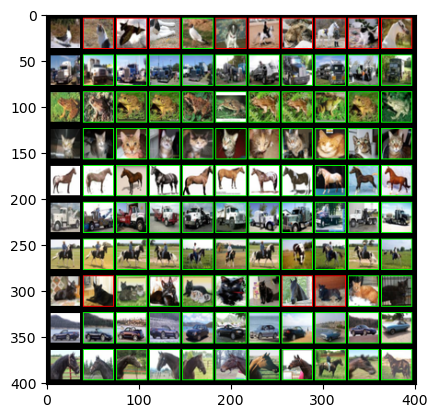

In [31]:
# Testing of the system on 10 random queries, with top-K results taken into consideration
num_runs = 10
K = 10

big_grid = []

for i in range(num_runs):
    # Extract a random query image from the database
    query_img_idx = np.random.randint(0, num_images_test)
    query_img = database_test_df.iloc[query_img_idx]['image']#.unflatten(0, unflatten_shape)
    query_ftrs = database_test_df.iloc[query_img_idx]['vit_b_32']
    query_label = database_test_df.iloc[query_img_idx]['label']

    # Multiply the database matrix and the query feature vector (to be done for each query vector)
    match_scores = database_matrix @ query_ftrs
    sorted_scores, sorted_ind = torch.sort(torch.Tensor(match_scores), descending=True)

    # Take K best matches
    k_best_ind = sorted_ind[0:K].numpy()

    # Grid
    grid_list = list(database_train_df.iloc[k_best_ind]['image'])

    # query_img = cv.copyMakeBorder(torch.tensor(query_img).permute(1,2,0).numpy(), 1, 1, 1, 1, cv.BORDER_CONSTANT, None, value=0)
    query_img = cv.copyMakeBorder(query_img.transpose(1,2,0), 1, 1, 1, 1, cv.BORDER_CONSTANT, None, value=0)
    # query_img = torch.tensor(query_img).permute(2,0,1)
    query_img = query_img.transpose(2,0,1)

    for j, img in enumerate(grid_list):
        # img = torch.tensor(img).permute(1,2,0).numpy()
        img = img.transpose(1,2,0)
        
        color = (0,1,0) if query_label == database_train_df.iloc[k_best_ind[j]]['label'] else (1,0,0)
        img_with_border = cv.copyMakeBorder(img, 1, 1, 1, 1, cv.BORDER_CONSTANT, None, value=color)

        # grid_list[j] = torch.tensor(img_with_border).permute(2,0,1)
        grid_list[j] = torch.Tensor(img_with_border.transpose(2,0,1))

    grid_list = [torch.Tensor(query_img)] + grid_list # add query as first image
    grid = make_grid(grid_list, nrow=K+1)

    big_grid.append(grid)

    # Save images to img_save_folder
    # img_path = img_save_folder + img_name + str(i) + '.png'
    # save_image(grid, img_path)

big_grid = make_grid(big_grid, nrow=1, normalize=True)

save_image(big_grid, img_save_folder + 'cifar10_big_vit_b32.png')

plt.imshow(big_grid.permute(1,2,0))

In [23]:
# Calculate the average precision for each query in the test set and save in a tensor for further analysis
ap_test_set = torch.zeros(num_images_test)

database_labels = torch.tensor(database_train_df['label'])

for i in tqdm(range(num_images_test)):
    query_img = database_test_df.iloc[i]['image']#.unflatten(0, unflatten_shape)
    query_ftrs = database_test_df.iloc[i]['vit_b_32']
    query_label = database_test_df.iloc[i]['label']
    
    target = torch.where(database_labels == query_label, True, False)

    # Multiply the database matrix and the query feature vector
    preds = database_matrix @ query_ftrs

    ap_test_set[i] = retrieval_average_precision(torch.tensor(preds), target)

100%|██████████| 10000/10000 [02:51<00:00, 58.33it/s]


In [24]:
# Save the average precision for all queries from the test set, for easier access and analysis
torch.save(ap_test_set, img_save_folder + 'cifar10_vitb32_avg_precision.pkl')

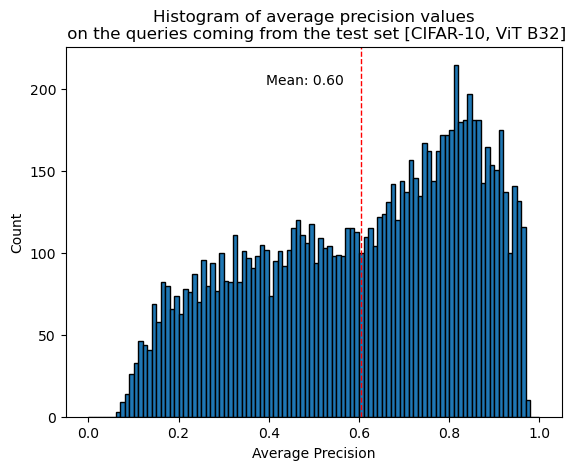

In [25]:
# Plot the histogram of average precisions:
result = plt.hist(ap_test_set.numpy(), bins=100, range=(0,1), edgecolor='k')
plt.xlabel('Average Precision')
plt.ylabel('Count')
plt.title('Histogram of average precision values\n on the queries coming from the test set [CIFAR-10, ViT B32]')
plt.axvline(ap_test_set.mean(), color='r', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(ap_test_set.mean()*0.65, max_ylim*0.9, 'Mean: {:.2f}'.format(ap_test_set.mean()))
plt.savefig(img_save_folder+'histogram_of_precisions_vit_b32.png', dpi=300)

In [26]:
# Plot the image that achieved the highest average precision
max_ap = ap_test_set.max()
max_idx = ap_test_set.argmax()

best_query_img = database_test_df.iloc[max_idx.item()]['image']
best_query_label = database_test_df.iloc[max_idx.item()]['label']

plt.imshow((best_query_img.permute(1,2,0) - best_query_img.min()) / np.ptp(best_query_img))
plt.title(f'Query Image with the highest average precision \n {max_ap: .4f}')

AttributeError: 'numpy.ndarray' object has no attribute 'permute'

Text(0.5, 1.0, 'Query Image with the lowest average precision \n  0.0638')

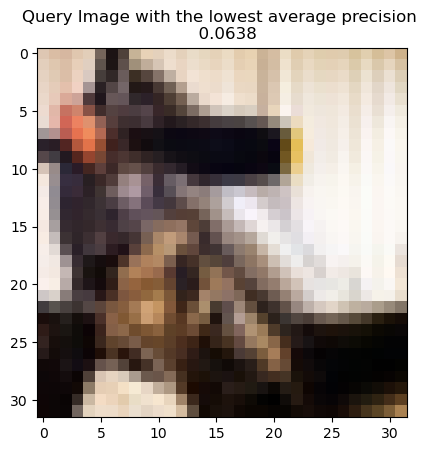

In [179]:
# Plot the image that achieved the lowest average precision
min_ap = ap_test_set.min()
min_idx = ap_test_set.argmin()

worst_query_img = database_test_df.iloc[min_idx.item()]['image']
worst_query_label = database_test_df.iloc[min_idx.item()]['label']

plt.imshow((worst_query_img.permute(1,2,0) - worst_query_img.min()) / np.ptp(worst_query_img))
plt.title(f'Query Image with the lowest average precision \n {min_ap: .4f}')